## Metric Learning using Triplet Loss

In [1]:
# common imports
import os
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# local imports
import dataset as custom_dataset
import losses
import model as custom_models
from plotting import plot_umap, create_gif_from_rgb_list, display_gif, plot_image_grid
%matplotlib inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
datasets = {"mnist":[28,1,True], "cifar10":[32,3, True], "fer2013":[48,1, False]}
dataset_name = "cifar10" 
dataset_image_size, dataset_image_channels, dataset_test_labels_available = datasets[dataset_name]
# common objects
test_dataset = custom_dataset.choose_test_dataset(dataset_name=dataset_name)

# define device
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [3]:
@torch.no_grad()
def compute_embeddings(model, dataset, device, labels_available=True, embedding_dim=256, batch_size=64):
    dataset_len = len(dataset)
    out_embeddings = np.zeros((dataset_len, embedding_dim))
    if labels_available:
        out_labels = np.zeros((dataset_len))
    else:
        out_labels = None

    dataloader = DataLoader(dataset, 
                            batch_size=batch_size,
                            num_workers=4,
                            shuffle=False)
    model.to(device)
    model.eval()
    for i, data in enumerate(dataloader):
        img, label = data
        img, label = img.to(device), label.to(device)
        # compute embedding 
        x = model(img) #[1, 1, H, W] -> [1, d]
        # append to list
        out_embeddings[i*batch_size:(i+1)*batch_size, :] = x.cpu().numpy()
        if labels_available:
            out_labels[i*batch_size:(i+1)*batch_size] = label.cpu().numpy() #[B]
    return out_embeddings, out_labels

In [4]:
import torch.nn.functional as F

# pairwise distance matrix computation
"""
Pairwise distance using the property:

||a-b||^2 = ||a||^2 - 2* <a,b> + ||b||^2

||a||^2 and ||b||^2 can be computed with unsqueezing of diagonal of pariwise dot product matrix

"""
def euclidean_distance_matrix(x):
    """
    Efficient computation of Euclidean distance matrix
    Args:
    x: Input tensor of shape (batch_size, embedding_dim)

    Returns:
    Distance matrix of shape (batch_size, batch_size)
    """
    # step 1 - compute the dot product

    # shape: (batch_size, batch_size)
    dot_product = torch.mm(x, x.t())

    # step 2 - extract the squared Euclidean norm from the diagonal

    # shape: (batch_size,)
    squared_norm = torch.diag(dot_product)

    # step 3 - compute squared Euclidean distances

    # shape: (batch_size, batch_size)
    distance_matrix = squared_norm.unsqueeze(0) - 2 * dot_product + squared_norm.unsqueeze(1)

    # get rid of negative distances due to numerical instabilities
    distance_matrix = F.relu(distance_matrix)

    # step 4 - compute the non-squared distances  
    # handle numerical stability
    # derivative of the square root operation applied to 0 is infinite
    # we need to handle by setting any 0 to eps
    mask = (distance_matrix == 0.0).float()

    # use this mask to set indices with a value of 0 to eps
    distance_matrix = distance_matrix +  mask * eps

    # now it is safe to get the square root
    distance_matrix = torch.sqrt(distance_matrix)

    # undo the trick for numerical stability
    distance_matrix = distance_matrix * (1.0 - mask) # set the zeros back to zero instead of eps

    return distance_matrix


# valid triplet computation
"""
Three steps:
(1) Compute a mask for distinct indices, e.g., (i != j and j != k).
(2) Compute a mask for valid anchor-positive-negative triplets, e.g., labels[i] == labels[j] and labels[j] != labels[k].
(3) Combine two masks.

"""
def get_triplet_mask(labels):
    """compute a mask for valid triplets
    Args:
    labels: Batch of integer labels. shape: (batch_size,)
    Returns:
    Mask tensor to indicate which triplets are actually valid. Shape: (batch_size, batch_size, batch_size)
    A triplet is valid if:
    `labels[i] == labels[j] and labels[i] != labels[k]`
    and `i`, `j`, `k` are different.
    """
    # step 1 - get a mask for distinct indices

    # shape: (batch_size, batch_size)
    indices_equal = torch.eye(labels.size()[0], dtype=torch.bool, device=labels.device)
    indices_not_equal = torch.logical_not(indices_equal)
    # shape: (batch_size, batch_size, 1)
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    # shape: (batch_size, 1, batch_size)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    # shape: (1, batch_size, batch_size)
    j_not_equal_k = indices_not_equal.unsqueeze(0)
    # Shape: (batch_size, batch_size, batch_size)
    distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    # step 2 - get a mask for valid anchor-positive-negative triplets

    # shape: (batch_size, batch_size)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    # shape: (batch_size, batch_size, 1)
    i_equal_j = labels_equal.unsqueeze(2)
    # shape: (batch_size, 1, batch_size)
    i_equal_k = labels_equal.unsqueeze(1)
    # shape: (batch_size, batch_size, batch_size)
    valid_indices = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k))

    # step 3 - combine two masks
    mask = torch.logical_and(distinct_indices, valid_indices)
    return mask


class BatchAllTripletLoss(nn.Module):
    """
    Uses all valid triplets to compute Triplet loss
    Args:
    margin: Margin value in the Triplet Loss equation
    """
    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        """computes loss value.
        Args:
          embeddings: Batch of embeddings, e.g., output of the encoder. shape: (batch_size, embedding_dim)
          labels: Batch of integer labels associated with embeddings. shape: (batch_size,)
        Returns:
          Scalar loss value.
        """
        # step 1 - get distance matrix
        # shape: (batch_size, batch_size)
        distance_matrix = euclidean_distance_matrix(embeddings)

        # step 2 - compute loss values for all triplets by applying broadcasting to distance matrix

        # shape: (batch_size, batch_size, 1)
        anchor_positive_dists = distance_matrix.unsqueeze(2)
        # shape: (batch_size, 1, batch_size)
        anchor_negative_dists = distance_matrix.unsqueeze(1)
        # get loss values for all possible n^3 triplets
        # shape: (batch_size, batch_size, batch_size)
        triplet_loss = anchor_positive_dists - anchor_negative_dists + self.margin

        # step 3 - filter out invalid or easy triplets by setting their loss values to 0

        # shape: (batch_size, batch_size, batch_size)
        mask = get_triplet_mask(labels)
        triplet_loss = triplet_loss * mask
        # easy triplets have negative loss values
        triplet_loss = F.relu(triplet_loss)

        # step 4 - compute scalar loss value by averaging positive losses
        num_positive_losses = (triplet_loss > eps).float().sum()
        triplet_loss = triplet_loss.sum() / (num_positive_losses + eps)

        return triplet_loss

In [5]:
num_epochs = 30
batch_size = 64
num_workers = 4
learning_rate = 1e-4
print_freq = 500 # minibatches
eps = 1e-6

# Define a log directory for TensorBoard
log_dir = "./logs/triplet"

# Create a SummaryWriter
writer = SummaryWriter(log_dir)

# Start TensorBoard
%tensorboard --logdir ./logs/triplet

Files already downloaded and verified
[Epoch: 0, Batch: 499] Loss: 0.9710


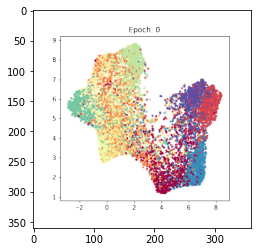

[Epoch: 1, Batch: 217] Loss: 0.9671
[Epoch: 1, Batch: 717] Loss: 1.0302


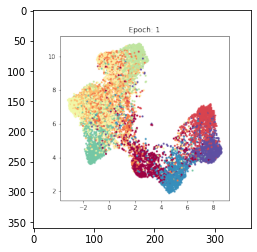

[Epoch: 2, Batch: 435] Loss: 1.1606


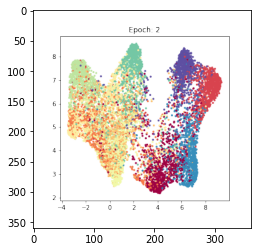

[Epoch: 3, Batch: 153] Loss: 1.0632
[Epoch: 3, Batch: 653] Loss: 1.1293


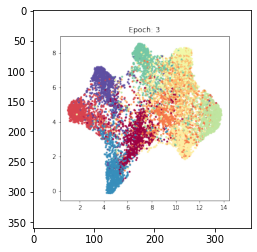

[Epoch: 4, Batch: 371] Loss: 0.9608


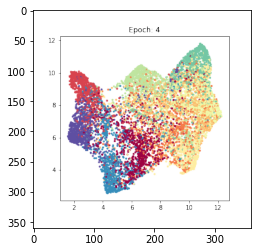

[Epoch: 5, Batch: 89] Loss: 1.0169
[Epoch: 5, Batch: 589] Loss: 1.0171


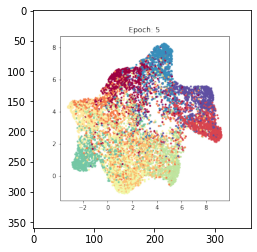

[Epoch: 6, Batch: 307] Loss: 1.0744


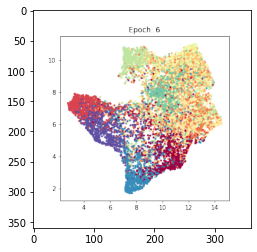

[Epoch: 7, Batch: 25] Loss: 1.0448
[Epoch: 7, Batch: 525] Loss: 1.0062


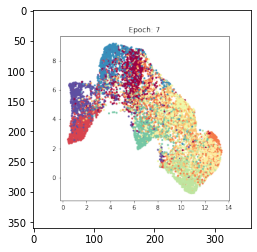

[Epoch: 8, Batch: 243] Loss: 1.1273
[Epoch: 8, Batch: 743] Loss: 0.7348


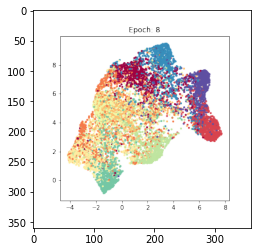

[Epoch: 9, Batch: 461] Loss: 0.9017


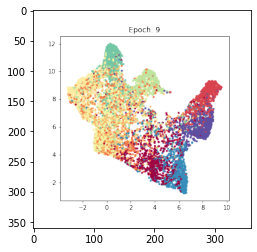

[Epoch: 10, Batch: 179] Loss: 0.9947
[Epoch: 10, Batch: 679] Loss: 1.0163


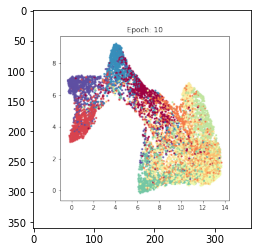

[Epoch: 11, Batch: 397] Loss: 1.0856


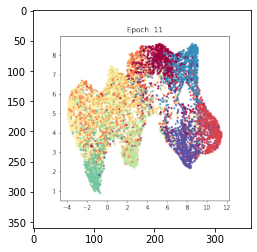

[Epoch: 12, Batch: 115] Loss: 1.1804
[Epoch: 12, Batch: 615] Loss: 0.9214


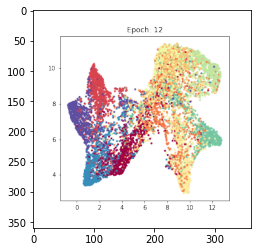

[Epoch: 13, Batch: 333] Loss: 0.9888


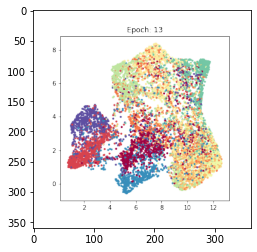

[Epoch: 14, Batch: 51] Loss: 1.0730
[Epoch: 14, Batch: 551] Loss: 1.1135


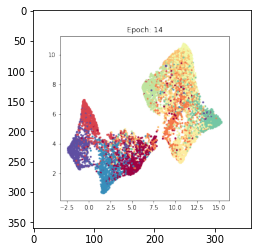

[Epoch: 15, Batch: 269] Loss: 0.8414
[Epoch: 15, Batch: 769] Loss: 1.0158


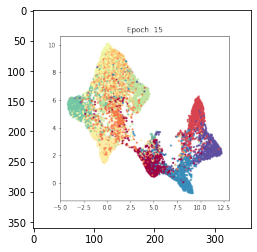

[Epoch: 16, Batch: 487] Loss: 1.0666


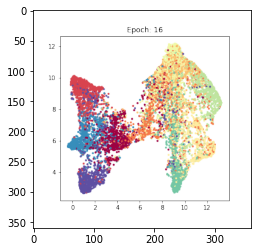

[Epoch: 17, Batch: 205] Loss: 0.8771
[Epoch: 17, Batch: 705] Loss: 0.9990


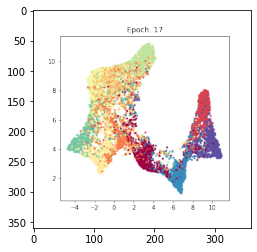

[Epoch: 18, Batch: 423] Loss: 1.0487


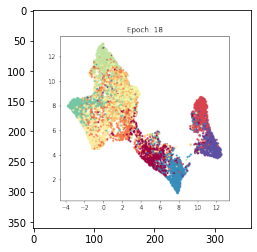

[Epoch: 19, Batch: 141] Loss: 1.0433
[Epoch: 19, Batch: 641] Loss: 1.0138


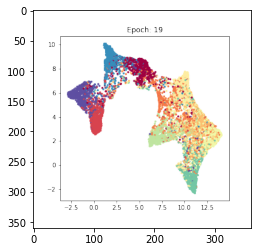

[Epoch: 20, Batch: 359] Loss: 0.9260


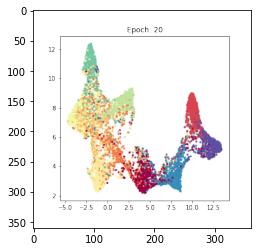

[Epoch: 21, Batch: 77] Loss: 1.2383
[Epoch: 21, Batch: 577] Loss: 1.0467


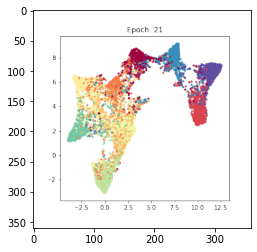

[Epoch: 22, Batch: 295] Loss: 0.8823


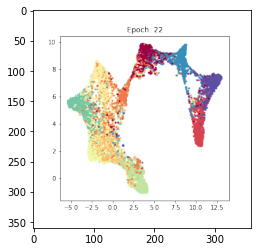

[Epoch: 23, Batch: 13] Loss: 1.0834
[Epoch: 23, Batch: 513] Loss: 0.9090


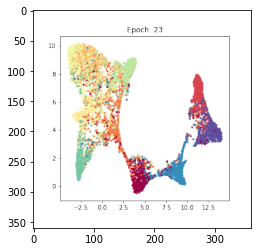

[Epoch: 24, Batch: 231] Loss: 0.8915
[Epoch: 24, Batch: 731] Loss: 1.0048


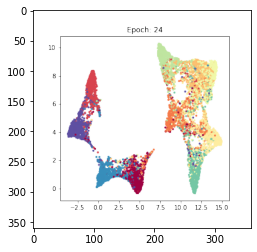

[Epoch: 25, Batch: 449] Loss: 1.0463


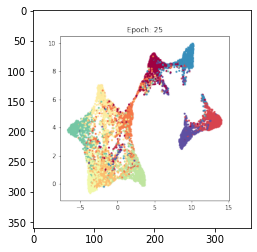

[Epoch: 26, Batch: 167] Loss: 0.9883
[Epoch: 26, Batch: 667] Loss: 0.9936


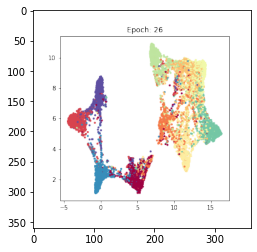

[Epoch: 27, Batch: 385] Loss: 0.8689


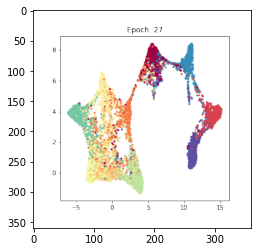

[Epoch: 28, Batch: 103] Loss: 0.9407
[Epoch: 28, Batch: 603] Loss: 1.1637


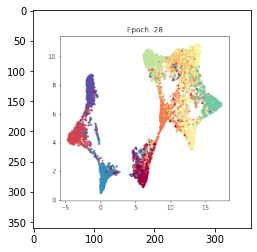

[Epoch: 29, Batch: 321] Loss: 0.6559


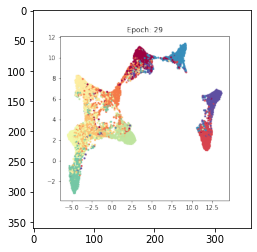

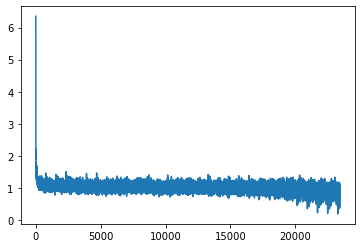

In [6]:
# instantiate model, dataset, dataloader, optimizer
dataset = custom_dataset.Classification_Dataset(dataset_name=dataset_name)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

model = custom_models.ResNet9(dataset_image_channels,
                        dataset.num_classes)
model = model.to(device)
embedding_dim = model.out
criterion = BatchAllTripletLoss(margin=1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                                steps_per_epoch=len(dataloader),
                                               epochs=num_epochs)

umap_plots = []
loss_history = []
step = 0
running_loss = 0.0

# train loop
for epoch in range(num_epochs):    
    model.train()
    for i_batch, data in enumerate(dataloader):
        img, labels = data
        
        # send data to device
        img, labels = img.to(device), labels.to(device)

        # predict using model
        embeddings = model(img) #[B, d]

        # compute loss, backward, update optimizer
        loss = criterion(embeddings, labels)

        running_loss += loss.item()        
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print stuff
        step += 1
        if step % print_freq == 0:
            print("[Epoch: %d, Batch: %d] Loss: %0.4f"%(epoch, i_batch, loss.item()))
            writer.add_scalar('total loss', running_loss / print_freq, step)
            writer.add_scalar('lr', scheduler.get_last_lr()[0], step)
            running_loss = 0.0
            
    # testing loop
    model.eval()
    test_embeddings, test_labels = compute_embeddings(model, 
                                                      test_dataset,
                                                      device,
                                                      embedding_dim=embedding_dim, 
                                                      labels_available=dataset_test_labels_available)
    
    title = "Epoch: %d"%(epoch)
    i_plot = plot_umap(test_embeddings, test_labels, title=title)
    
    plt.imshow(i_plot)
    plt.show()
    plt.close()

# plot loss
fig = plt.figure()
plt.plot(loss_history)
plt.show()
plt.close(fig)

### Take-Away
For triplet loss, we can see clustering happening but with the batchall strategy the loss oscillattes a lot. Perhaps, other mining strategy will yield better results.
Learning the distance matrix tricks to calculate triplet loss efficiently was fun.